In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

In [2]:
passengers = pd.read_csv('passengers.csv', sep=';')

In [3]:
passengers['datetime'] = pd.to_datetime(passengers['Month'])

In [4]:
passengers = passengers.set_index('datetime')

In [5]:
passengers = passengers.drop('Month', axis=1)

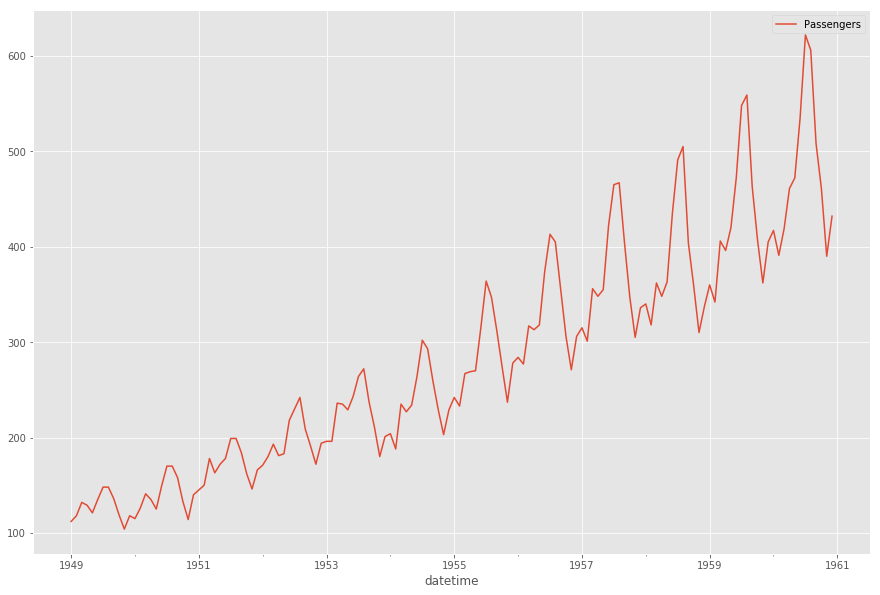

In [6]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 10))
    ax = passengers.plot(label='observed')

Let's fit a simple ARIMA model, where we simply chose 1 AR order and 1 MA order. We also include seasonality of 12 months in this regression - but there's no need to worry about it!

In [9]:
from IPython.core.debugger import set_trace

def meboot(x: pd.Series, num_replicates=1):
    '''
    Maximum Entropy Time Series Bootstrap as described in:
    https://cran.r-project.org/web/packages/meboot/vignettes/meboot.pdf
    The algorithm (described below) creates an (x.shape[0], num_replicates) DataFrame of replicated time series designed to mimic the properties of the given time series. Bootstrap samples are used to study the relation between the sample and the (unknown) population by a comparible relation between the sample at hand and appropriately designed (observable) resamples. The Maximum Entropy (ME) Bootstrap extends the traditional bootstrap to nonstationary dependent data.
    Original R source code:
    https://rdrr.io/cran/meboot/f/
    The steps of the algorithm are:
    1. Sort the original data in increasing order to create order statistics x_(t) t=1,...,T and store the ordering index vector.
    2. Compute intermediate points z_t = (x_(t) + x_(t+1))/2 from the order statistics
    3. Compute the trimmed mean, m_trimmed, of the deviations x_t - x_{t-1} among all consecutive observations. Compute the lower limit for the left tail as x_(1) - m_trimmed and the upper limie for the right tail as x_(T) + m_trimmed. The limits become the limiting intermediate points.
    4. Compute the mean of the maximum entropy density within each interval such that the 'mean preserving constraint' (designed to satify the ergodic theorem) is satisfied. Interval means are denoted m_t. The means for the first and last interval have simpler formulas.
    5. Generate random numbers from the [0, 1] uniform interval, and compute sample quantiels of the ME density at those points and sort them.
    6. Reorder the sorted sample quantiles by using the ordering index of step 1. This recovers the time dependence relationships of the originally observed data.
    7. Repeat steps 2 to 6 num_replicates times.
    Parameters
    ----------------------
    x : pd.Series
      The original Time Series to create replicates for.
    num_replicates : int
      The number of replicates to create.
    Returns
    -----------------------
    replicates : pd.DataFrame
      A (x.shape[0], num_replicates) DataFrame containing the Maximum Entropy replicates of x as columns.
    Examples
    -----------------------
    x = my_series
    replicates = meboot(x, num_replicates=100)
    '''

    if not isinstance(x, pd.Series):
        raise TypeError(f'`x` should be a pandas.Series')

    # 1
    sorted_x = x.sort_values()
    xt = sorted_x.values

    # 3 + 2
    trimmed_mean = x.diff().abs().mean()
    zt = np.hstack((
        xt[0] - trimmed_mean,
        (xt[:-1] + xt[1:]) / 2,
        xt[-1] + trimmed_mean
    ))

    # 4
    desired_means = np.hstack((
        0.75 * xt[0] + 0.25 * xt[1],
        0.25 * xt[:-2] + 0.5 * xt[1:-1] + 0.25 * xt[2:],
        0.75 * xt[-1] + 0.25 * xt[-2]
    ))

    # 5
    xr = np.linspace(0, 1, len(x) + 1)
    U = np.sort(np.random.rand(num_replicates, len(x))).transpose()
    inds = np.searchsorted(xr, U, side='right') - 1

    lin_interp = desired_means[inds] - (zt[inds] - zt[inds + 1]) / 2
    y0 = zt[inds] + lin_interp
    y1 = zt[inds + 1] + lin_interp

    quantiles = (y0 + ((U - xr[inds]) * (y1 - y0)) / (xr[inds + 1] - xr[inds]))
    replicates = pd.DataFrame(quantiles, index=sorted_x.index)

    # 6
    return replicates.reindex(x.index)

In [12]:
x = passengers
col = 'Passengers'
replicates = meboot(x[col], num_replicates=100)

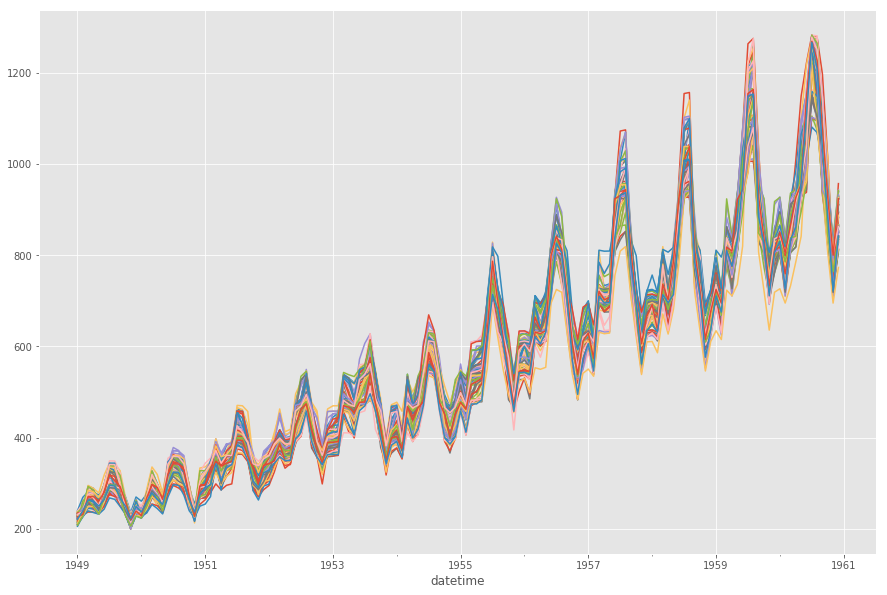

In [17]:
replicates.plot(legend=False, figsize=(15, 10))

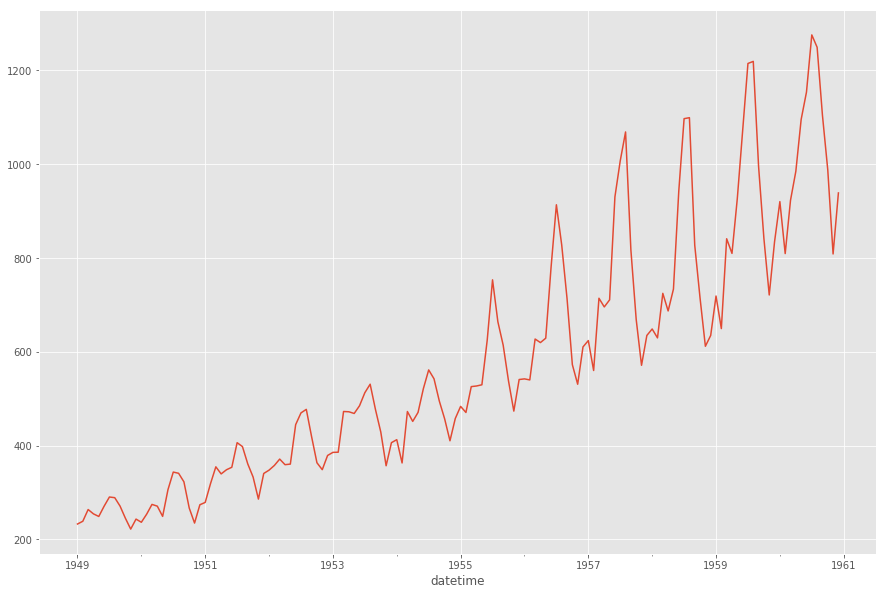

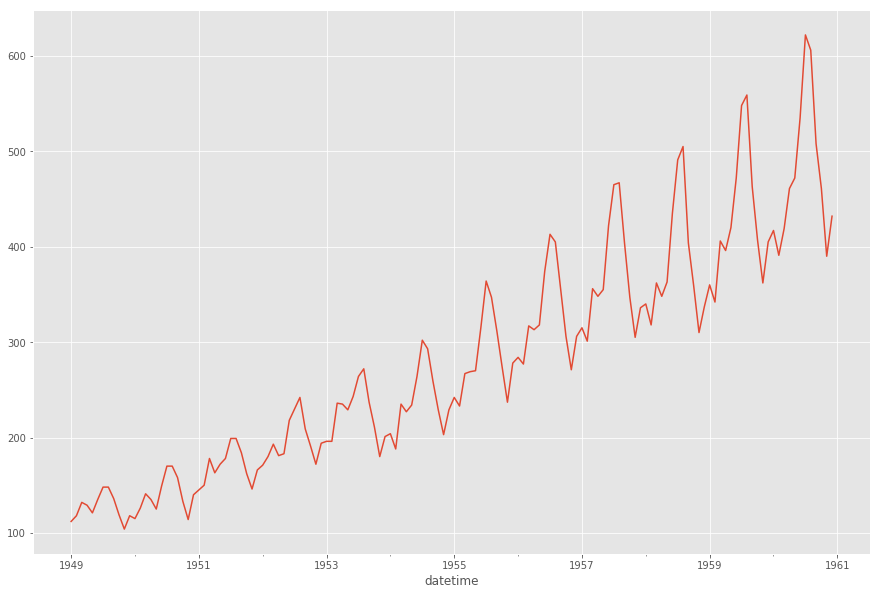

In [16]:
replicates[50].plot(legend=False, figsize=(15, 10))
passengers.plot(legend=False, figsize=(15, 10))